![](img/TOC_600x.png)

# pyPRISM Basics

In this notebook, we'll go though the various pieces of `pyPRISM` and how we go about setting up a "problem" in the `pyPRISM` environment. We start with a classic physical system: a hard-sphere fluid. 

## Concepts
- `pyPRISM` basics
- posing problems in `pyPRISM`


## Notebook Setup
To begin, please run `Kernel-> Restart & Clear Output` from the menu at the top of the notebook. It is a good idea to run this before starting any notebook so that the notebook is fresh for the user. Next, run the cell below (via the top menu-bar or `<Shift-Enter>`. If the cell throws an import error, there is likely something wrong with your environment.

If successful, you should see a set of logos appear below the cell. Which logos appear depend on what is inside the `hv.extension()` command at the bottom of the cell. If no logos appear and the cell throws an error, there is likely something wrong with your environment. 

### Troubleshooting:
- Did you activate the correct conda environment before starting the jupyter notebook? 
- If not using anaconda, did you install all dependencies before starting the jupyter notebook? 
- Is pyPRISM installed in your current environment on your `PYTHONPATH`? 

Holoviews + Bokeh Logos: ![Logos](img/import_check_bokeh.png)


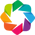

In [1]:
import pyPRISM
import numpy as np
import matplotlib.pyplot as plt
import holoviews as hv

hv.extension('bokeh') 

## Create System

To start, we define a "System" object which will contain all of the information that will specify the structure and interactions (chemistry) of a given system. In this case, our goal is to set up the calculation for a simple, hard-sphere monomer solution. We define the system to have 1 site-type called "monomer" and we define the reduced temperature to be $k_{B}T=1.0$. 

In [2]:
sys = pyPRISM.System(['monomer'],kT=1.0)

## Define Domain

Next, we need to define the numerical solution domain. In other words, we must define the Real- and Fourier- space grid that we will solve the equations on. We do this by specifying the grid spacing in Real-space (dr) and the number of points in the grid (length). Specifying these values fixes both the Real- and Fourier- space grid, and we could have alternatively specified the Fourier-space grid spacing (dk). Note that it is best for efficiency if the length is a power of 2. 

In [3]:
sys.domain = pyPRISM.Domain(dr=0.005,length=32768)
print('r =',sys.domain.r)
print('k = ',sys.domain.k)

r = [5.00000e-03 1.00000e-02 1.50000e-02 ... 1.63830e+02 1.63835e+02
 1.63840e+02]
k =  [1.91747598e-02 3.83495197e-02 5.75242795e-02 ... 6.28280181e+02
 6.28299356e+02 6.28318531e+02]


## Define Interactions

Now we'll define the interactions of the monomer solution. This effectively represents the chemistry of the system by defining how the sites attract or repel one another. For this example, we'll be examining a simple, hard-sphere fluid.

In [4]:
diameter = 1.0
sys.diameter['monomer'] = diameter
sys.potential['monomer','monomer'] = pyPRISM.potential.HardSphere(sigma=diameter)

## Define Composition

The composition of a system in PRISM theory is defined via site number densities. Since this is a one component system, we only need to specify one density. 

In [5]:
sys.density['monomer'] = 0.8
sys.density

<Density total:0.80>

## Define Molecular Structure

In general, the molecular structure is specified *via* $\hat{\omega}(k)$ in PRISM calculations. These functions are essentially form-factors which describe the *intra*-molecular correlations within a molecule. It is through these functions that the molecular structure of a system is described and arbitrarily complicated $\hat{\omega}(k)$ are possible. In this case of a simple hard-sphere fluid, $\hat{\omega}(k)=1$ for all $k$ by definition.

In [6]:
sys.omega['monomer','monomer'] = pyPRISM.omega.SingleSite()

## Define Closure Approximation 

In order to solve the PRISM equations numerically, an extra closure-approximation must be provided for each pair of sites. A detailed explanation of various closures is slightly beyond the scope of this introductory tutorial. A few guidelines are provided below

- The PercusYevick (PY) closure is a good starting point for most systems with divergent (hard-core, Weeks-Chandler-Andersen, Lennard-Jones) interactions.
- The HypernettedChain (HNC) closure is more accurate than PY for pairs of sites that have very different diameters. This is very useful knowledge when studying composite systems. 

In [7]:
sys.closure['monomer','monomer'] = pyPRISM.closure.PercusYevick()

## Create PRISM Object and Solve

Finally, we take the System object and use it to spawn a PRISM object. We have created the "System" and "PRISM" classes because they have separate, specific roles. The System class *defines* the structure and interactions of a given system while the PRISM class contains the machinery for setting up, solving, and storing the results of the mathematical PRISM formalism. After solve() is called, the result of the calculation is stored in the PRISM object.

In [8]:
PRISM = sys.createPRISM()
PRISM.solve()

0:  |F(x)| = 2.62378; step 1; tol 0.266006
1:  |F(x)| = 1.7493; step 1; tol 0.400054
2:  |F(x)| = 0.639398; step 1; tol 0.144039
3:  |F(x)| = 0.171478; step 1; tol 0.064732
4:  |F(x)| = 0.0061731; step 1; tol 0.00116635
5:  |F(x)| = 3.6306e-06; step 1; tol 3.1131e-07


     fun: array([ 4.17341710e-09,  1.25429946e-08,  2.08562607e-08, ...,
       -5.17318299e-12, -3.97103469e-12, -2.60420128e-12])
 message: 'A solution was found at the specified tolerance.'
     nit: 7
  status: 1
 success: True
       x: array([7.31923234e-02, 2.18136517e-01, 3.61390574e-01, ...,
       5.29541161e-12, 3.84880607e-12, 2.72637439e-12])

## Plotting the Results

To start, we'll plot the pair correlation function of this system. We calculate this value by passing the **solved** PRISM object to a calculation function.

In [9]:
%opts Curve Scatter Area [width=500,height=400] 
%opts Scatter (size=10,alpha=0.5)

x = sys.domain.r 
y = pyPRISM.calculate.pair_correlation(PRISM)['monomer','monomer']
rdf1 = hv.Curve((x,y),extents=(0,0,6,4),label='BaseRDF').redim.label(x='r',y='g(r)')
rdf1

/Users/tbm/anaconda3/envs/pyPRISM_py3_dev/lib/python3.5/site-packages/bokeh/core/json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):


:Curve   [x]   (y)

We could instead calculate the structure factor of this system

In [10]:
%opts Curve Scatter Area [width=500,height=400] 
%opts Scatter (size=10,alpha=0.5)

x = sys.domain.r 
y = pyPRISM.calculate.structure_factor(PRISM)['monomer','monomer']
hv.Curve((x,y),extents=(0,0,6,None)).redim.label(x='k',y='S(k)')

/Users/tbm/anaconda3/envs/pyPRISM_py3_dev/lib/python3.5/site-packages/bokeh/core/json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):


:Curve   [x]   (y)

Or maybe the second virial coefficient

In [11]:
B2 = pyPRISM.calculate.second_virial(PRISM)['monomer','monomer']
print('The monomer-monomer second-virial coefficient for this system is',B2)

The monomer-monomer second-virial coefficient for this system is 0.6042889421237424


## Putting It All Together

The above steps were long and detailed, but it's important to realize that we only executed a few lines of code, shown below. Try changing the density, closures, and interactions and see how these changes affect the pair-correlation function. A few suggestions are below:

- change the closure to
    -  sys.closure['monomer','monomer'] = pyPRISM.closure.HypernettedChain()
    -  sys.closure['monomer','monomer'] = pyPRISM.closure.MSA(apply_hard_core=True)
- change the site diameter
    - diameter = 0.75
- change the density 
    - density = 0.6

In [12]:
%opts Curve Scatter Area [width=500,height=400] 
%opts Scatter (size=10,alpha=0.5)

diameter = 1.0

sys = pyPRISM.System(['monomer'],kT=1.0)
sys.domain = pyPRISM.Domain(dr=0.005,length=32768)
sys.diameter['monomer'] = diameter
sys.potential['monomer','monomer'] = pyPRISM.potential.WeeksChandlerAndersen(epsilon=1.0,sigma=diameter)
sys.density['monomer'] = 0.9
sys.omega['monomer','monomer'] = pyPRISM.omega.SingleSite()
sys.closure['monomer','monomer'] = pyPRISM.closure.HyperNettedChain(apply_hard_core=True)
PRISM = sys.createPRISM()
PRISM.solve()

x = sys.domain.r 
y = pyPRISM.calculate.pair_correlation(PRISM)['monomer','monomer']
rdf2 = hv.Curve((x,y),extents=(0,0,6,6),label='ModifiedRDF').redim.label(x='r',y='g(r)')

hv.Overlay([rdf1,rdf2])

0:  |F(x)| = 4.66521; step 0.131777; tol 0.689986
1:  |F(x)| = 4.14728; step 0.135086; tol 0.711257
2:  |F(x)| = 3.47396; step 0.331376; tol 0.63149
3:  |F(x)| = 3.33707; step 0.372518; tol 0.830469
4:  |F(x)| = 3.33674; step 0.499758; tol 0.899824
5:  |F(x)| = 3.33669; step 0.211348; tol 0.899971
6:  |F(x)| = 3.33669; step 1; tol 0.899999
7:  |F(x)| = 3.3368; step 1; tol 0.900059
8:  |F(x)| = 3.33665; step 0.499983; tol 0.899922
9:  |F(x)| = 3.33673; step 1; tol 0.900043
10:  |F(x)| = 3.33673; step 0.0264183; tol 0.899998
11:  |F(x)| = 2.87558; step 1; tol 0.728996
12:  |F(x)| = 2.54183; step 0.148712; tol 0.703208
13:  |F(x)| = 2.11321; step 0.336146; tol 0.622063
14:  |F(x)| = 1.77386; step 0.24706; tol 0.63416
15:  |F(x)| = 1.50726; step 0.227031; tol 0.6498
16:  |F(x)| = 1.35027; step 0.122946; tol 0.722284
17:  |F(x)| = 1.17685; step 0.16853; tol 0.683667
18:  |F(x)| = 0.972883; step 0.326404; tol 0.615061
19:  |F(x)| = 0.820462; step 0.200511; tol 0.640086
20:  |F(x)| = 0.651431

/Users/tbm/anaconda3/envs/pyPRISM_py3_dev/lib/python3.5/site-packages/bokeh/core/json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):


:Overlay
   .Curve.BaseRDF     :Curve   [x]   (y)
   .Curve.ModifiedRDF :Curve   [x]   (y)

## Getting Extra Help
Besides going to the documentation website (see Github page) or compiling the documentation yourself, Jupyter provides a few ways to access the documentation in the notebook. Try running the cell below.

In [13]:
pyPRISM.potential.WeeksChandlerAndersen?

Alternatively, if you are inside the parenthesis of a function call, typing `<Shift-Tab>` will bring up a small,floating documentation popup. Try this below:

In [14]:
pyPRISM.potential.WeeksChandlerAndersen(epsilon=1.0,sigma=1.0)

<Potential: WeeksChandlerAndersen>

## Summary

In this notebook, we stepped through the process of constructing a PRISM calculation in pyPRISM for a standard system in liquid state theory: the hard sphere fluid. We went over each step of the pyPRISM calculation in detail and then calculated several thermodynamic and structural quantities from the converged equations. In the following notebooks, we will move on to convering several real word systems and attempt to reproduce published data from scientific literature. 

![](img/tutorial_tracks_600x.png)
[NB0.Introduction](NB0.Introduction.ipynb) $\cdot$   [NB1.PythonBasics](NB1.PythonBasics.ipynb) $\cdot$   [NB2.Theory.General](NB2.Theory.General.ipynb) $\cdot$   [NB3.Theory.PRISM](NB3.Theory.PRISM.ipynb) $\cdot$   [NB4.pyPRISM.Overview](NB4.pyPRISM.Overview.ipynb) $\cdot$   [NB5.CaseStudies.PolymerMelts](NB5.CaseStudies.PolymerMelts.ipynb) $\cdot$   [NB6.CaseStudies.Nanocomposites](NB6.CaseStudies.Nanocomposites.ipynb) $\cdot$   [NB7.CaseStudies.Copolymers](NB7.CaseStudies.Copolymers.ipynb) $\cdot$   [NB8.pyPRISM.Internals](NB8.pyPRISM.Internals.ipynb) $\cdot$   [NB9.pyPRISM.Advanced](NB9.pyPRISM.Advanced.ipynb)

## Legal

### Disclaimer
Any identification of commercial or open-source software in these notebooks is done so purely in order to specify the methodology adequately. Such identification is not intended to imply recommendation or endorsement by the National Institute of Standards and Technology, nor is it intended to imply that the softwares identified are necessarily the best available for the purpose. 

### License
This software was developed by employees of the National Institute of Standards and Technology (NIST), an agency of the Federal Government. Pursuant to title 17 United States Code Section 105, works of NIST employees are not subject to copyright protection in the United States and are considered to be in the public domain. Permission to freely use, copy, modify, and distribute this software and its documentation without fee is hereby granted, provided that this notice and disclaimer of warranty appears in all copies.

THE SOFTWARE IS PROVIDED 'AS IS' WITHOUT ANY WARRANTY OF ANY KIND, EITHER EXPRESSED, IMPLIED, OR STATUTORY, INCLUDING, BUT NOT LIMITED TO, ANY WARRANTY THAT THE SOFTWARE WILL CONFORM TO SPECIFICATIONS, ANY IMPLIED WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE, AND FREEDOM FROM INFRINGEMENT, AND ANY WARRANTY THAT THE DOCUMENTATION WILL CONFORM TO THE SOFTWARE, OR ANY WARRANTY THAT THE SOFTWARE WILL BE ERROR FREE. IN NO EVENT SHALL NIST BE LIABLE FOR ANY DAMAGES, INCLUDING, BUT NOT LIMITED TO, DIRECT, INDIRECT, SPECIAL OR CONSEQUENTIAL DAMAGES, ARISING OUT OF, RESULTING FROM, OR IN ANY WAY CONNECTED WITH THIS SOFTWARE, WHETHER OR NOT BASED UPON WARRANTY, CONTRACT, TORT, OR OTHERWISE, WHETHER OR NOT INJURY WAS SUSTAINED BY PERSONS OR PROPERTY OR OTHERWISE, AND WHETHER OR NOT LOSS WAS SUSTAINED FROM, OR AROSE OUT OF THE RESULTS OF, OR USE OF, THE SOFTWARE OR SERVICES PROVIDED HEREUNDER.

Distributions of NIST software should also include copyright and licensing statements of any third-party software that are legally bundled with the code in compliance with the conditions of those licenses.